# Inputs

In [1]:
proposal_id = 'testproposal'
proposal_company_id = "test_competitor_everlywell"
country = 'GB'
system_path = "/Users/jeeyenpersonal/Documents/kaya-services/services"
google_cred_path = ''

In [2]:
# Parameters
proposal_company_id =  "e4r1KpsJsZ0YOwld8hxZ"
country = "us"
proposal_id = "2rFE0i58OwiG2S7eroAZ" 
system_path = "/Users/jeeyenpersonal/Documents/kaya-services/services/ad_research/.."
google_cred_path = "/Users/jeeyenpersonal/Documents/kaya-services/services/ad_research/../../.local/kaya-apps-00-prod.json"


# Library

In [3]:
import os
import sys

print(system_path)
sys.path.append(system_path) # go to parent dir

/Users/jeeyenpersonal/Documents/kaya-services/services/ad_research/..


In [4]:
from secret_manager.set_env_variables_from_secrets import set_env_variables_from_secrets

In [5]:
os.environ['GCP_PROJECT_NAME'] = 'kaya-apps-00'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = google_cred_path
os.environ['ENV'] = 'LOCAL_PROD'

In [6]:
set_env_variables_from_secrets(secret_ids=["ALGOLIA_API_KEY", "SPYFU_API_KEY", "OPENAI_API_KEY", "SPYFU_AUTH_SECRET"])

Set environment variable for ALGOLIA_API_KEY
Set environment variable for SPYFU_API_KEY
Set environment variable for OPENAI_API_KEY
Set environment variable for SPYFU_AUTH_SECRET


In [7]:
import uuid
import json
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

from algoliasearch.search_client import SearchClient

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from firestore import FirestoreClient

from ad_research.semrush import query_semrush
from ad_research.proposal_company import ProposalCompany
from enums.ad_platform import AdPlatform, get_ad_platform_by_var_name

from storage.upload_blob import upload_blob
from storage.download_blob import download_blob_into_string

from utils.list import remove_duplicates_from_list_of_dict

from open_ai.run_chat_completions import run_chat_completions

Initialising Firestore App:  {'kaya-apps-00'}


In [8]:
_FS = FirestoreClient()

In [9]:
_IMAGE_BUCKET = "kaya-apps-00-public"
_AD_RAW_BUCKET = "kaya-ads-research"

In [10]:
proposal_company = ProposalCompany(proposal_company_id, proposal_id)

['bing_ads.json', 'google_ads.json', 'linkedin_ads.json', 'tiktok_ads.json']
Downloaded storage object e4r1KpsJsZ0YOwld8hxZ/bing_ads.json from bucket kaya-ads-research as string
Downloaded storage object e4r1KpsJsZ0YOwld8hxZ/google_ads.json from bucket kaya-ads-research as string
Downloaded storage object e4r1KpsJsZ0YOwld8hxZ/linkedin_ads.json from bucket kaya-ads-research as string
Downloaded storage object e4r1KpsJsZ0YOwld8hxZ/tiktok_ads.json from bucket kaya-ads-research as string


In [11]:
proposal_company_name = proposal_company.business_name
proposal_company_domain = proposal_company.domain
print(proposal_company_name, proposal_company_domain)

Ascential Technologies ascentialtech.com


# Initialisation

In [12]:
faq_list_to_save = []
is_test = False

# Functions

In [13]:
def write_list_into_str(items):
    """Format a list of strings into a single string with commas and 'and'."""
    if not items:
        return ''
    elif len(items) == 1:
        return items[0]
    else:
        return ', '.join(items[:-1]) + ' and ' + items[-1]

In [14]:
def generate_ad_copy_summary(company_name, ad_copies_str_list, channel_display_name):
    system_prompt = (
        "You are a performance marketer who is skilled at paid ads."
    )
    user_prompt_1 = f"""
    Summarize the unique selling points (maximum 5 points) and target audience (maximum 5 points highlighted by the company {company_name} in their sample {channel_display_name}. Your responses must be grammarly correct and succinct. Follow the format:
    
    1. Target Audience
        · audience 1
        · audience 2
        · audience 3
    2. Unique Selling Points
        · usp 1
        · usp 2
        · usp 3
        
    If you cannot generate any summary, return ''
    """
    
    
    ad_copies_str = f"Here are their ads:\n" + "\n".join(ad_copies_str_list)

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt_1},
        {"role": "user", "content": ad_copies_str},
    ]
    # print(messages)
    summary = run_chat_completions(messages)
    return summary

In [15]:
def save_and_upload_fig(fig, filename_with_ext, proposal_id, proposal_company_id):
    fig.write_image(filename_with_ext)

    filename = filename_with_ext.replace('/tmp/', '')

    storage_url = upload_blob(
        _IMAGE_BUCKET, 
        source_file_name=filename_with_ext, 
        destination_blob_name=f"proposal/{proposal_id}/{proposal_company_id}/{filename}", 
        is_public=True
    )
    return storage_url

In [16]:
def get_breakdown(df, index, value, aggfunc, rename_cols, output_fmt="records"):
    breakdown_by_channel_df = pd.pivot_table(
        df,
        index=index,
        aggfunc=aggfunc,
        values=value
    )
    if breakdown_by_channel_df.shape[0] == 0:
        return []
    
    breakdown_by_channel_df = breakdown_by_channel_df.sort_values(by=value, ascending=False).rename(columns=rename_cols).reset_index()
    
    if output_fmt == "records":
        out = breakdown_by_channel_df.to_dict(orient='records')
        return out
    
    return breakdown_by_channel_df

In [17]:
def update_fs_about_no_ads_found(proposal_company_id):
    _FS.update_document(
        "proposal_companies",
        proposal_company_id,
        {
            'freeform_summary': f"{proposal_company_name} is not actively running ads.",
            'freeform_updates': f"{proposal_company_name} is not actively running ads."
        }
    )
    return None
    

# Get all ads

## Get ads from algolia

In [18]:
alg_client = SearchClient.create("9UOFA9X1DB", os.environ['ALGOLIA_API_KEY'])

In [19]:
# Create a new index and add a record
ad_research_sample_index = alg_client.init_index("ad_research_sample")

In [20]:
all_ads_out = ad_research_sample_index.browse_objects(
    {"filters": f"proposal_company_id:{proposal_company_id}"}
)

In [21]:
all_ads_algolia = [a for a in all_ads_out]

In [22]:
if len(all_ads_algolia) == 0:
    update_fs_about_no_ads_found(proposal_company_id)
    raise Exception("No ads found in Algolia")

In [23]:
# all_ads[:5]

In [24]:
all_ads_df = pd.DataFrame(all_ads_algolia)

In [25]:
print(all_ads_df.shape)

if all_ads_df.shape[0] == 0:
    update_fs_about_no_ads_found(proposal_company_id)
    raise Exception(f"Terminating. No ads found for {proposal_company_id}..")

(6, 24)


In [26]:
all_ads_df['platform_format'] = all_ads_df['platform'] + "_" + all_ads_df['format'] 

In [27]:
all_ads_df.groupby('platform_format')['ad_id'].count()

platform_format
google_ads_image_single    1
google_ads_text            5
Name: ad_id, dtype: int64

# Determine platforms with ads

- Identify which platforms
- Update firestore

In [28]:
channels_with_ads = list(all_ads_df['platform'].unique())

In [29]:
_FS.update_document(
    "proposal_companies",
    proposal_company_id,
    {'stacks': channels_with_ads}
)

Doc e4r1KpsJsZ0YOwld8hxZ updated


### Process missing first and last seen

In [30]:
today = dt.date.today()
a_year_ago = today - relativedelta(years=1)
print("a_year_ago: ", a_year_ago)

# assign default probability of 1
all_ads_df['probability'] = 1.0

# assign probability of 0.5 if first_seen or last_seen is null
filter_null_first_seen = all_ads_df['first_seen'].isnull()
all_ads_df.loc[filter_null_first_seen, 'first_seen'] = a_year_ago
all_ads_df.loc[filter_null_first_seen, 'probability'] = 0.5

filter_null_last_seen = all_ads_df['last_seen'].isnull()
all_ads_df.loc[filter_null_last_seen, 'last_seen'] = today
all_ads_df.loc[filter_null_last_seen, 'probability'] = 0.5

a_year_ago:  2023-06-27


### Process dates

In [31]:
for sm in ['first_seen', 'last_seen']:
    all_ads_df[f'{sm}_month'] = all_ads_df[sm].astype(str).str[:7]
    all_ads_df[f'{sm}_dt'] = pd.to_datetime(all_ads_df[sm])

In [32]:
all_ads_df['days_active'] = (all_ads_df['last_seen_dt'] - all_ads_df['first_seen_dt']).dt.days + 1

In [33]:
all_ads_df.head()

platform   channels        format    advertiser_social_id  \
0  google_ads   [search]          text  AR08594132424315633665   
1  google_ads   [search]          text  AR08594132424315633665   
2  google_ads   [search]          text  AR08594132424315633665   
3  google_ads  [display]  image_single  AR08594132424315633665   
4  google_ads   [search]          text  AR08594132424315633665   

          advertiser_name                   ad_id  \
0  William Stone Cressman  CR18175758334848663553   
1  William Stone Cressman  CR15508560485569003521   
2  William Stone Cressman  CR15142073812419346433   
3  William Stone Cressman  CR11568504135581958145   
4  William Stone Cressman  CR06231332513759887361   

                                           image_url video_url  first_seen  \
0  https://tpc.googlesyndication.com/archive/simg...      None  2024-02-05   
1  https://tpc.googlesyndication.com/archive/simg...      None  2024-02-05   
2  https://tpc.googlesyndication.com/archive/simg...      None  2024-02-05   
3  https://tpc.googlesyndication.com/archive/simg...      None  2024-05-06   
4  https://tpc.googlesyndication.com/archive/simg...      None  2024-02-04   

    last_seen  ...   tags num_tags is_featured  \
0  2024-06-27  ...  [B2B]        1       False   
1  2024-06-26  ...  [B2B]        1       False   
2  2024-06-26  ...  [B2B]        1       False   
3  2024-06-03  ...  [B2B]        1       False   
4  2024-05-03  ...  [B2B]        1       False   

                            objectID          platform_format probability  \
0  google_ads_CR18175758334848663553          google_ads_text         1.0   
1  google_ads_CR15508560485569003521          google_ads_text         1.0   
2  google_ads_CR15142073812419346433          google_ads_text         1.0   
3  google_ads_CR11568504135581958145  google_ads_image_single         1.0   
4  google_ads_CR06231332513759887361          google_ads_text         1.0   

  first_seen_month first_seen_dt last_seen_month last_seen_dt  
0          2024-02    2024-02-05         2024-06   2024-06-27  
1          2024-02    2024-02-05         2024-06   2024-06-26  
2          2024-02    2024-02-05         2024-06   2024-06-26  
3          2024-05    2024-05-06         2024-06   2024-06-03  
4          2024-02    2024-02-04         2024-05   2024-05-03  

[5 rows x 30 columns]

## Get G Ads from storage

In [34]:
google_ads_storage_data = json.loads(
    download_blob_into_string(
        _AD_RAW_BUCKET, f"{proposal_company_id}/google_ads.json"
    )
)

Downloaded storage object e4r1KpsJsZ0YOwld8hxZ/google_ads.json from bucket kaya-ads-research as string


In [35]:
gads_copies_df = pd.DataFrame(google_ads_storage_data['copies'])
print(gads_copies_df.shape)

if gads_copies_df.shape[0] > 0:
    gads_copies_df.columns = [x.lower().replace(' ', '_') for x in gads_copies_df.columns]

    gads_copies_df.rename(
        columns={'title': 'headline', 'description': 'body', 'dt': 'first_seen', 'url': 'landing_page_url'},
        inplace=True
    )
    gads_copies_df['dt'] = gads_copies_df['searchdateid'].apply(lambda x: dt.datetime.strptime(str(x), '%Y%m%d'))
    gads_copies_df['yyyymm'] = gads_copies_df['dt'].apply(lambda x: x.strftime('%Y%m'))
    
    gads_copies_df['number_of_keywords'] = gads_copies_df['keywords'].apply(lambda x: len(x))

    gads_copies_df['platform'] = 'google_ads'
    gads_copies_df['format'] = 'text'
    gads_copies_df.rename(columns={'adid': 'ad_id'}, inplace=True)


(6, 7)


In [36]:
gads_copies_df.head()

keywords  position  searchdateid  \
0      [vitality medical.com, companies engineering]         1      20240301   
1  [medical cart manufacturers, order medical sup...         1      20240301   
2                     [industrial engineering firms]         1      20240301   
3                                    [merck medical]         1      20240301   
4                [new product development companies]         3      20240301   

                                            headline  \
0   D&K Engineering - Medical Contract Manufacturing   
1                                                Ad·   
2               D&K Engineering | ISO13485 Certified   
3  D&K Engineering - Medical & Life Sciences - Sc...   
4  D&K Engineering | ISO13485 Certified | 21CFR82...   

                                                body  \
0  Reduce time to market with our engineering exp...   
1  Reduce time to market with our engineering exp...   
2  Reduce time to market with our engineering exp...   
3  Reduce time to market with our engineering exp...   
4  Reduce time to market with our engineering exp...   

            landing_page_url       ad_id         dt  yyyymm  \
0  http://ascentialtech.com/   390243466 2024-03-01  202403   
1  http://ascentialtech.com/   292744984 2024-03-01  202403   
2  http://ascentialtech.com/  2133547877 2024-03-01  202403   
3  http://ascentialtech.com/ -1689100468 2024-03-01  202403   
4  http://ascentialtech.com/  1781728261 2024-03-01  202403   

   number_of_keywords    platform format  
0                   2  google_ads   text  
1                   3  google_ads   text  
2                   1  google_ads   text  
3                   1  google_ads   text  
4                   1  google_ads   text

In [37]:
gads_keywords_df = pd.DataFrame(google_ads_storage_data['keywords'])

if gads_keywords_df.shape[0] > 0:
    gads_keywords_df.columns = [x.lower().replace(' ', '_') for x in gads_keywords_df.columns]

## Combine semrush and algolia

In [38]:
all_ads_with_semrush_df = pd.concat([
    all_ads_df[all_ads_df['platform_format'] != 'google_ads_text'],
    gads_copies_df
])

In [39]:
pd.pivot_table(
    all_ads_with_semrush_df,
    index=['platform', 'format'],
    aggfunc='count',
    values='ad_id'
)

ad_id
platform   format             
google_ads image_single      1
           text              6

## Process all ads

### Count num words in copies

In [40]:
def add_word_count_col_to_df(df):
    if "headline" not in df.columns:
        df['headline'] = ''

    if "body" not in df.columns:
        df['body'] = ''

    df['headline_word_count'] = df['headline'].apply(lambda x: len(str(x)))
    df['body_word_count'] = df['body'].apply(lambda x: len(str(x)))
    return df

In [41]:
all_ads_with_semrush_df = add_word_count_col_to_df(all_ads_with_semrush_df)

In [42]:
all_ads_df = add_word_count_col_to_df(all_ads_df)

In [43]:
all_ads_df.head().T

0  \
platform                                                     google_ads   
channels                                                       [search]   
format                                                             text   
advertiser_social_id                             AR08594132424315633665   
advertiser_name                                  William Stone Cressman   
ad_id                                            CR18175758334848663553   
image_url             https://tpc.googlesyndication.com/archive/simg...   
video_url                                                          None   
first_seen                                                   2024-02-05   
last_seen                                                    2024-06-27   
days_active                                                         144   
uuid                               99fcc45b-6554-41d8-ae43-b2d719dbd947   
landing_page_url                                                   None   
proposal_company_id                                e4r1KpsJsZ0YOwld8hxZ   
proposal_id                                        2rFE0i58OwiG2S7eroAZ   
business_name                                    Ascential Technologies   
domain                                                ascentialtech.com   
industry                                         Industrial Engineering   
sub_industry                                                              
description           Ascential Technologies designs, develops, and ...   
tags                                                              [B2B]   
num_tags                                                              1   
is_featured                                                       False   
objectID                              google_ads_CR18175758334848663553   
platform_format                                         google_ads_text   
probability                                                         1.0   
first_seen_month                                                2024-02   
first_seen_dt                                       2024-02-05 00:00:00   
last_seen_month                                                 2024-06   
last_seen_dt                                        2024-06-27 00:00:00   
headline                                                                  
body                                                                      
headline_word_count                                                   0   
body_word_count                                                       0   

                                                                      1  \
platform                                                     google_ads   
channels                                                       [search]   
format                                                             text   
advertiser_social_id                             AR08594132424315633665   
advertiser_name                                  William Stone Cressman   
ad_id                                            CR15508560485569003521   
image_url             https://tpc.googlesyndication.com/archive/simg...   
video_url                                                          None   
first_seen                                                   2024-02-05   
last_seen                                                    2024-06-26   
days_active                                                         143   
uuid                               44c6f4f7-928c-4fef-aa55-c2aa96c6212c   
landing_page_url                                                   None   
proposal_company_id                                e4r1KpsJsZ0YOwld8hxZ   
proposal_id                                        2rFE0i58OwiG2S7eroAZ   
business_name                                    Ascential Technologies   
domain                                                ascentialtech.com   
industry                                         Industrial Engineering   
sub_industry       

## Get SEM SEO traffic data from SEMRUSH

In [44]:
spyfu_data_id = f"{proposal_company_domain}_{proposal_company_id}_{proposal_id}"

In [45]:
from google.gutils.bigquery import run_query

In [46]:
from http.client import HTTPSConnection
from base64 import b64encode

# Authorization token: we need to base 64 encode it 
# and then decode it to acsii as python 3 stores it as a byte string
def basic_auth(username, password):
    token = b64encode(f"{username}:{password}".encode('utf-8')).decode("ascii")
    return f'Basic {token}'

In [47]:
sql = """
select distinct id
from kaya-apps-00.src_coin.spyfu_domain_adwords_organic_traffic_cost_stats
"""
existing_semrush_id_df = run_query(sql, "dataframe")

Executing query:
 
select distinct id
from kaya-apps-00.src_coin.spyfu_domain_adwords_organic_traffic_cost_stats



In [48]:
existing_semrush_ids = list(existing_semrush_id_df['id'].unique())
existing_semrush_ids

['tecan.com_BXXrAnQqaVRuMQaWWMUA_2rFE0i58OwiG2S7eroAZ',
 'gener8.net_MeEs8bKDWU2vFJMAkMik_2rFE0i58OwiG2S7eroAZ',
 'jrautomation.com_ArcPooBoPz2DGBl7DiB7_2rFE0i58OwiG2S7eroAZ',
 'ascentialtech.com_e4r1KpsJsZ0YOwld8hxZ_2rFE0i58OwiG2S7eroAZ',
 'bench.com_fLBdce4XWtQduVhpO8dq_2rFE0i58OwiG2S7eroAZ',
 'atsautomation.com_1ihfocHTS0tgpRTHOfEM_2rFE0i58OwiG2S7eroAZ',
 'adp.com_Cs2QYDztaRa0jV0aBM9b_R6q0XkcExJ9zws1RNyqu',
 'brita.com_d13SWUzDlOQaeFVnUNsC_9YJQWolIoQ2coRMfYc5U',
 'gusto.com_sNuvKddKL1wFSFkxz9KA_R6q0XkcExJ9zws1RNyqu',
 'elicit.com_qfETlqRalsckC5qGV2PP_roSs4DvgGMavK0W0Ao5m',
 'birdeye.com_PQ6qCT2FxKSRQgokUo1E_IT5SyWDKOrshQEqad9rt',
 'syntrio.com/affordable-anonymous-hotline-reporting-ppc_SPmQVw8QzIBeL7GsHUk5_tSsv7RBQNHRCG9Goxepk',
 'quizlet.com_Y2WCUKoO3GIx6JAKuEm6_mhKEUKUHuhkZvG7ZXTIA',
 'sentry.com_qoFf6AdbbxXn3sBAFbHc_3icProMjo0SutpcuuYXa',
 'navex.com_5xBhvc5GSjOvC8rCTjZa_tSsv7RBQNHRCG9Goxepk',
 'perceptyx.com_8K2rVbCpFRsBQ0U5sYjT_tSsv7RBQNHRCG9Goxepk',
 '15five.com_LHmRqQ7HUBvT7k

In [49]:
def query_semrush_monthly_domain_seo_sem_data(domain):
    print("Querying Spyfu")
    conn = HTTPSConnection("www.spyfu.com")

    spyfu_traffic_dfs = []
    headers = {'Authorization': basic_auth(os.environ['SPYFU_AUTH_SECRET'], os.environ['SPYFU_API_KEY']) }

    conn.request("GET", f"/apis/domain_stats_api/v2/getAllDomainStats?domain={proposal_company_domain}", headers=headers)

    res = conn.getresponse()

    data = res.read()
    data_str = data.decode("utf-8")
    data_json = json.loads(data_str)

    search_budget_n_traffic_df = pd.DataFrame(data_json['results'])
    print(search_budget_n_traffic_df.shape)
    return search_budget_n_traffic_df

In [50]:
if spyfu_data_id in existing_semrush_ids:
    print("Found existing data in BQ")
    sql = f"""
    select *
    from kaya-apps-00.src_coin.spyfu_domain_adwords_organic_traffic_cost_stats
    where id = '{spyfu_data_id}'
    """
    search_budget_n_traffic_df = run_query(sql, "dataframe")
else:
    print("Querying new")
    search_budget_n_traffic_df = query_semrush_monthly_domain_seo_sem_data(proposal_company_domain)
    print("search_budget_n_traffic_df: ", search_budget_n_traffic_df.shape)

    if not search_budget_n_traffic_df.empty:
        cols_rename = {x: x.lower().replace(' ', '_') for x in search_budget_n_traffic_df.columns}
        search_budget_n_traffic_df.rename(columns=cols_rename, inplace=True)
        search_budget_n_traffic_df['domain'] = proposal_company_domain
        search_budget_n_traffic_df['yyyymm'] = search_budget_n_traffic_df.apply(lambda x: f"{x['searchyear']:.0f}-{x['searchmonth']:02.0f}", axis=1)

        search_budget_n_traffic_df['dt'] = search_budget_n_traffic_df['yyyymm'].apply(lambda x: dt.datetime.strptime(x+'-01', '%Y-%m-%d'))
        search_budget_n_traffic_df['adwords_cost'] = pd.to_numeric(search_budget_n_traffic_df['monthlybudget'])
        search_budget_n_traffic_df['cpc'] = pd.to_numeric(search_budget_n_traffic_df['adwords_cost'])/pd.to_numeric(search_budget_n_traffic_df['monthlypaidclicks'])

        search_budget_n_traffic_df['domain'] = proposal_company_domain
        search_budget_n_traffic_df['yyyymm'] = search_budget_n_traffic_df['dt'].astype(str).str[:7]
        search_budget_n_traffic_df['id'] = spyfu_data_id
        
        for col in [
            'averageorganicrank', 
            'monthlypaidclicks', 
            'averageadrank', 
            'monthlybudget',
            'monthlyorganicvalue',
            'monthlyorganicclicks',
            'adwords_cost', 
            'cpc'
        ]:
            search_budget_n_traffic_df[col] = pd.to_numeric(search_budget_n_traffic_df[col]).astype(float)

        # Upload to BQ
        search_budget_n_traffic_df.to_gbq(
            "kaya-apps-00.src_coin.spyfu_domain_adwords_organic_traffic_cost_stats",
            "kaya-apps-00",
            if_exists="append",
        )
    else:
        print("Spyfu monthly domain SEO and SEM data is empty!")


Found existing data in BQ
Executing query:
 
    select *
    from kaya-apps-00.src_coin.spyfu_domain_adwords_organic_traffic_cost_stats
    where id = 'ascentialtech.com_e4r1KpsJsZ0YOwld8hxZ_2rFE0i58OwiG2S7eroAZ'
    


# Competitor Overview: Across all platforms
- generate a summary that shows traffic vol by channel: MoM growth
- which channel is the focus now
- num new ads added and removed

In [51]:
channels_with_ad_names = [c.display_name for c in proposal_company.channel_with_ads]

In [52]:
channels_with_ad_names

['Google Ads', 'LinkedIn Ads']

In [53]:
company_data_to_update = {}

### Num active ads per month

In [54]:
def count_active_ads_per_month(df):
    # Create a monthly date range from the minimum start_date to maximum end_date
    start_min = df['first_seen_dt'].min()
    end_max = df['last_seen_dt'].max()

    # Create a date object for the first day of start_date and end_date month
    start_min_month = start_min.replace(day=1)
    end_max_month = end_max.replace(day=1)

    months = pd.date_range(start=start_min_month, end=end_max_month, freq='MS')

    # Initialize a dictionary to hold the count of active ads for each month
    active_ads_count = {month.strftime('%Y-%m'): 0 for month in months}

    # Check each ad against each month
    active_ads_count = []
    for month in months:
        month_end = month + pd.offsets.MonthEnd()
        count = df.apply(
            lambda x: x['first_seen_dt'] <= month_end and x['last_seen_dt'] >= month, axis=1
        ).sum()
        active_ads_count.append({'month': month.strftime('%Y-%m'), 'count': count})

    return active_ads_count

In [55]:
channels_with_ads

['google_ads']

In [56]:
active_ads_count_lst = []
for ch in channels_with_ads:
    print("Processing ", ch)
    tmp_ad_count_df = all_ads_df[
        (all_ads_df['platform']==ch) & (all_ads_df['probability'] == 1.0)
    ]
    print(tmp_ad_count_df.shape)
    
    if tmp_ad_count_df.shape[0] == 0:
        print("  Skipping since no data")
        continue 
        
    active_ads_count = count_active_ads_per_month(tmp_ad_count_df)
    active_ads_count_lst += [{**d, 'platform': ch} for d in active_ads_count]

Processing  google_ads
(6, 34)


In [57]:
active_ads_count_df = pd.DataFrame(active_ads_count_lst)
active_ads_count_df.head()

month  count    platform
0  2024-02      5  google_ads
1  2024-03      5  google_ads
2  2024-04      5  google_ads
3  2024-05      6  google_ads
4  2024-06      5  google_ads

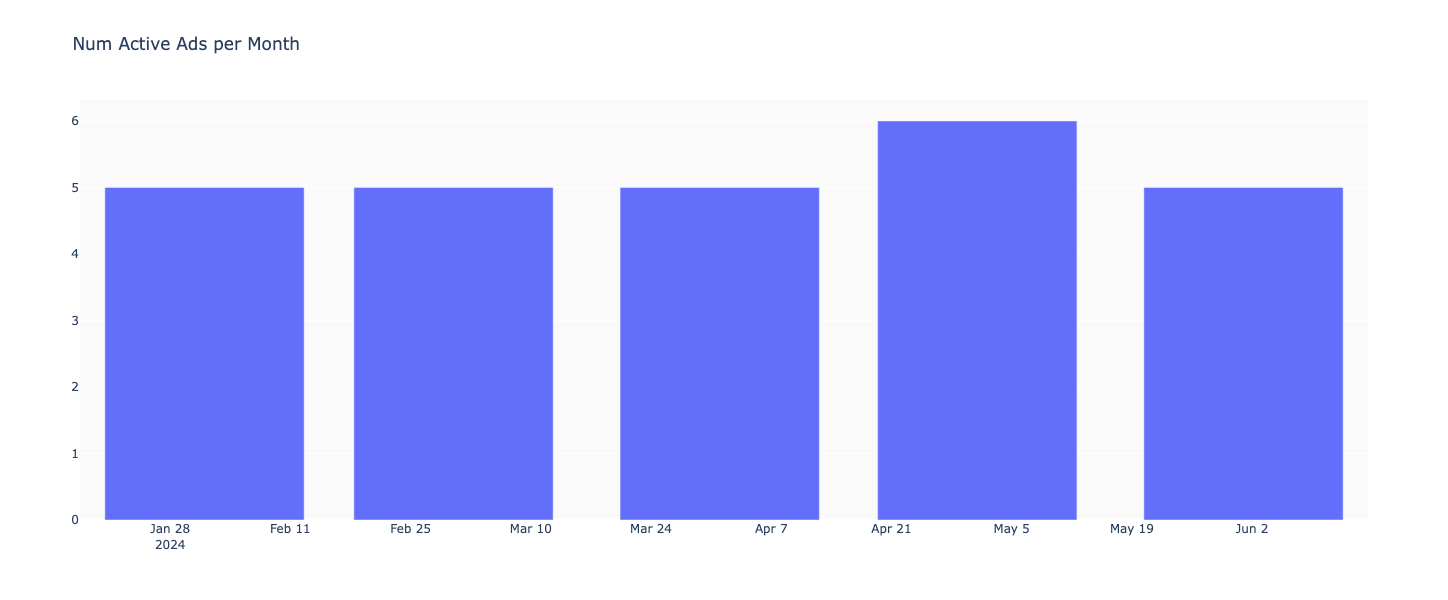

WARNING, FILE WILL BE MADE PUBLIC!
File /tmp/num_active_ads_per_month.png uploaded to kaya-apps-00-public/proposal/2rFE0i58OwiG2S7eroAZ/e4r1KpsJsZ0YOwld8hxZ/num_active_ads_per_month.png.
2024-06-27 00:00:00
2024-06-27
company_summary:
Ascential Technologies is still actively running ads. As of 2024-06-27, there are 5 ads in circulation across Google Ads
<br />
In the chart below, you can see the number of active ads since 2024-02.
![Active ads per month](https://storage.googleapis.com/kaya-apps-00-public/proposal/2rFE0i58OwiG2S7eroAZ/e4r1KpsJsZ0YOwld8hxZ/num_active_ads_per_month.png "Active ads per month")


In [58]:
if len(active_ads_count_df) > 0:
    # PLOT ACTIVE ADS
    fig = go.Figure()

    for up in active_ads_count_df['platform'].unique():
        up_plot_df = active_ads_count_df[active_ads_count_df['platform'] == up]
        fig.add_trace(
            go.Bar(x=up_plot_df['month'], y=up_plot_df['count'], name=up)
        )
    fig.update_layout(
        barmode='relative', 
        title_text='Num Active Ads per Month',
        height=600, 
        width=1000, 
        legend=dict(orientation="h"),
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='#fafafa'
    )
    fig.show()

    active_ads_per_month_storage_url = save_and_upload_fig(
        fig,
        "/tmp/num_active_ads_per_month.png",
        proposal_id,
        proposal_company_id
    )


    # PREPARE SUMMARY FOR ACTIVE ADS
    active_ads_count_df = active_ads_count_df.sort_values(by=['month', 'platform'], ascending=[False, True])
    latest_month_val = active_ads_count_df['month'].values[0]

    active_ads_latest_month_df = active_ads_count_df[active_ads_count_df['month'] == latest_month_val]

    if active_ads_latest_month_df.shape[0] > 0:
        as_of_date = all_ads_df['last_seen_dt'].max()
        as_of_date_str = as_of_date.strftime('%Y-%m-%d')
        print(as_of_date)

        num_active_ads = active_ads_latest_month_df['count'].sum()

        active_ad_channel_names = [
            get_ad_platform_by_var_name(ac).display_name
            for ac in active_ads_latest_month_df['platform'].unique()
        ]

        active_ad_channel_str = write_list_into_str(active_ad_channel_names)
        ads_last_seen_dt_str = all_ads_df['last_seen_dt'].max().strftime('%Y-%m-%d')

else:
    num_active_ads = 0


# PREPARE SUMMARY FOR POTENTIAL ADS
probable_ad_df = all_ads_df[all_ads_df['probability'] == 0.5]

if len(probable_ad_df) > 0:
    has_probable_ad_channel = True

    probable_ad_channel_names = [
        get_ad_platform_by_var_name(ac).display_name
        for ac in probable_ad_df['platform'].unique()
    ]
    probable_ad_channel_str = write_list_into_str(probable_ad_channel_names)

else:
    has_probable_ad_channel = False


# PUT SUMMARY TOGETHER
as_of_date = dt.date.today()
as_of_date_str = as_of_date.strftime('%Y-%m-%d')
print(as_of_date)

company_summary = ""

if num_active_ads > 0:
    company_summary += f"{proposal_company_name.title()} is still actively running ads. As of {as_of_date_str}, there are {num_active_ads} ads in circulation across {active_ad_channel_str}"

    if has_probable_ad_channel:
        company_summary += f", and potentially more {probable_ad_channel_str}"
    
    company_summary += "\n<br />\n"
    company_summary += f"In the chart below, you can see the number of active ads since {active_ads_count_df['month'].min()}."
    company_summary += f'\n![Active ads per month]({active_ads_per_month_storage_url} "Active ads per month")'

elif (num_active_ads == 0) and (has_probable_ad_channel):
    company_summary += f"{proposal_company_name.title()} is potentially running {probable_ad_channel_str}"
    company_summary += f"\nSee Platforms tab for more info"

elif (num_active_ads == 0) and not (has_probable_ad_channel):
    company_summary += f"{proposal_company_name.title()} is not actively running any ads. Their ads was last seen on {ads_last_seen_dt_str}"

    # update firestore
    print("No active ads found. Updating FS summary..")
    update_fs_about_no_ads_found(proposal_company_id)

company_data_to_update["freeform_summary"] = company_summary

print("company_summary:")
print(company_summary)

### Insight: Num new ads per month

### Insights: What's new

In [59]:
agg_by_first_seen_df = pd.pivot_table(
    all_ads_df,
    index='first_seen_month',
    columns='platform',
    aggfunc='count',
    values='ad_id'
)

Num new ads as of current month

In [60]:
def get_new_ads_as_of_month(all_ads_df, year_month:str):
    return all_ads_df[all_ads_df['first_seen_month'] == year_month].shape[0]

In [61]:
as_of_month = as_of_date_str[:7]
as_of_month

'2024-06'

In [62]:
num_new_ads_as_of_mth = get_new_ads_as_of_month(all_ads_df, as_of_month)

In [63]:
num_new_ads_as_of_mth

0

In [64]:
agg_by_first_seen_df

platform          google_ads
first_seen_month            
2024-02                    5
2024-05                    1

Num new ads previous month

In [65]:
# Calculate the date one month ago
one_month_ago_dt = dt.datetime.strptime(as_of_month + '-01', '%Y-%m-%d') - relativedelta(months=1)
one_month_ago_yyyymm = one_month_ago_dt.strftime("%Y-%m")

two_month_ago_dt = dt.datetime.strptime(as_of_month + '-01', '%Y-%m-%d') - relativedelta(months=2)
two_month_ago_yyyymm = two_month_ago_dt.strftime("%Y-%m")

three_month_ago_dt = dt.datetime.strptime(as_of_month + '-01', '%Y-%m-%d') - relativedelta(months=3)
three_month_ago_yyyymm = three_month_ago_dt.strftime("%Y-%m")


one_year_ago_dt = dt.datetime.strptime(as_of_month + '-01', '%Y-%m-%d') - relativedelta(years=1)
one_year_ago_yyyymm = one_year_ago_dt.strftime("%Y-%m")

print(one_month_ago_yyyymm, two_month_ago_yyyymm, three_month_ago_yyyymm, one_year_ago_yyyymm)

2024-05 2024-04 2024-03 2023-06


In [66]:
num_new_ads_last_month = get_new_ads_as_of_month(all_ads_df, one_month_ago_yyyymm)
num_new_ads_two_months_ago = get_new_ads_as_of_month(all_ads_df, two_month_ago_yyyymm)

In [67]:
if num_new_ads_two_months_ago > 0:
    new_ads_pct_chg = 100*(num_new_ads_last_month - num_new_ads_two_months_ago)/num_new_ads_two_months_ago

In [68]:
num_new_ads_two_months_ago

0

In [69]:
num_new_ads_last_month_explanation = ""

breakdown_change_lst = []
if num_new_ads_two_months_ago > 0 and num_new_ads_last_month > 0:
    pct_change_last_month = (num_new_ads_last_month - num_new_ads_two_months_ago)/num_new_ads_two_months_ago
    
    new_ads_months_comparison_df = pd.pivot_table(
        all_ads_df[all_ads_df['first_seen_month'].isin([one_month_ago_yyyymm, two_month_ago_yyyymm])],
        index='platform',
        columns='first_seen_month',
        aggfunc='count',
        values='ad_id'
    ).fillna(0)

    new_ads_months_comparison_df.rename(
        columns={one_month_ago_yyyymm: 'one_month_ago', two_month_ago_yyyymm: 'two_month_ago'},
        inplace=True
    )
    
    new_ads_months_comparison_df['pct_change'] =\
        (new_ads_months_comparison_df['one_month_ago'] - new_ads_months_comparison_df['two_month_ago'])/new_ads_months_comparison_df['two_month_ago']

    new_ads_months_comparison_df.sort_values(by=['one_month_ago'], ascending=False, inplace=True)

    
    for ix, row in new_ads_months_comparison_df.iterrows():
        breakdown_changes = ""
        breakdown_changes += f"{ix.replace('_', ' ').title()}: {row['one_month_ago']:.0f} (was {row['two_month_ago']:.0f}"
        breakdown_changes += f", {row['pct_change']*100:.1f}%)" if row['two_month_ago'] > 0 else ")"
        breakdown_changes += "\n"
        breakdown_change_lst.append(breakdown_changes)

    print(breakdown_change_lst)
elif num_new_ads_two_months_ago > 0 and num_new_ads_last_month == 0:
    breakdown_changes = []
    num_new_ads_last_month_explanation = "They also didn't launch any new ads last month."
    

Num new ads month on month

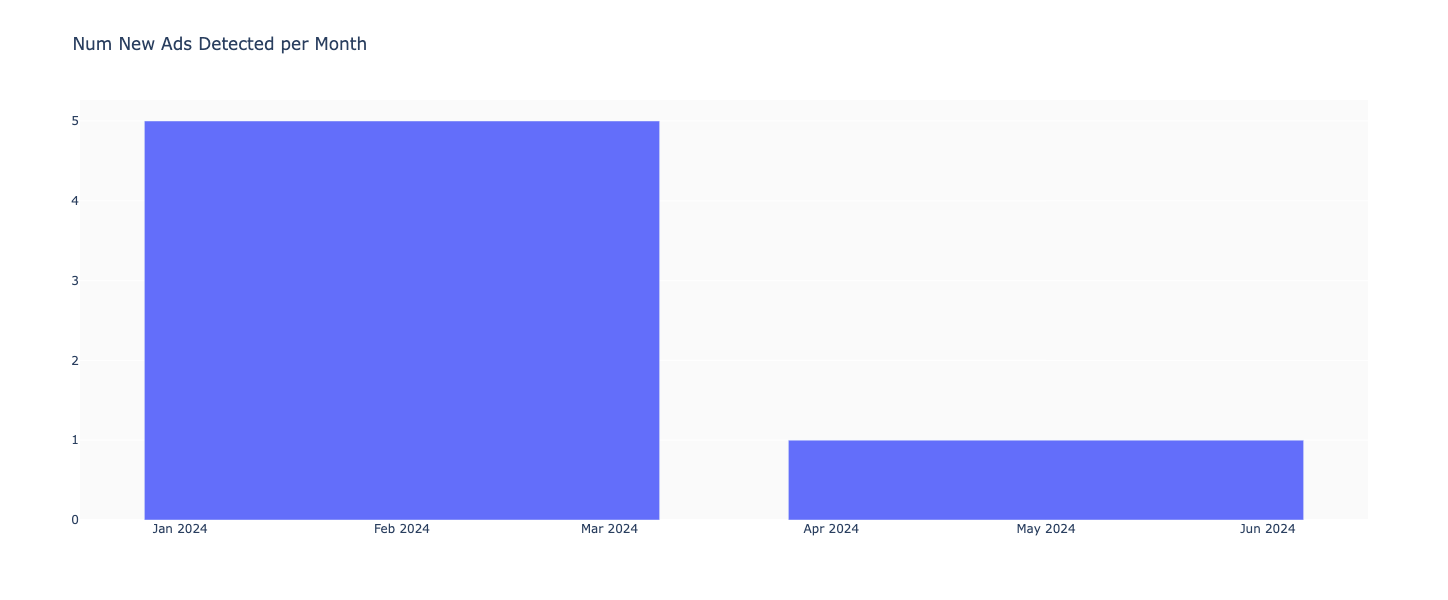

WARNING, FILE WILL BE MADE PUBLIC!
File /tmp/new_ad_detected_per_month_storage_url.png uploaded to kaya-apps-00-public/proposal/2rFE0i58OwiG2S7eroAZ/e4r1KpsJsZ0YOwld8hxZ/new_ad_detected_per_month_storage_url.png.


In [70]:
fig = go.Figure()

for c in agg_by_first_seen_df.columns:
    fig.add_trace(
        go.Bar(x=agg_by_first_seen_df.index, y=agg_by_first_seen_df[c], name=c)
    )
fig.update_layout(
    barmode='relative', 
    title_text='Num New Ads Detected per Month',
    height=600, 
    width=1000, 
    legend=dict(orientation="h"),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='#fafafa'
)
fig.show()

new_ad_detected_per_month_storage_url = save_and_upload_fig(
    fig,
    "/tmp/new_ad_detected_per_month_storage_url.png",
    proposal_id,
    proposal_company_id
)

Write summary

In [71]:
whats_new_summary = f"As of {as_of_date_str}, {proposal_company_name} has launched {num_new_ads_as_of_mth} ads month-to-date.\n"

if len(breakdown_change_lst) > 0:
    breakdwn_str = "\n· ".join(breakdown_change_lst)
    whats_new_summary +=f"""
In {one_month_ago_yyyymm}, {num_new_ads_last_month} new ads were found ({new_ads_pct_chg:.1f}% vs preceding month), with the following breakdown:
· {breakdwn_str}

From the chart below, you can see the number of new ads detected per month. 
![New ads per month]({new_ad_detected_per_month_storage_url} "New ads per month")
"""

whats_new_summary += num_new_ads_last_month_explanation

print(whats_new_summary)
# Any new format, landing pages

As of 2024-06-27, Ascential Technologies has launched 0 ads month-to-date.



In [72]:
company_data_to_update["freeform_updates"] = whats_new_summary

In [73]:
# LP breakdown
breakdown_by_lp_records = get_breakdown(
    all_ads_with_semrush_df, 
    index='landing_page_url',
    value='ad_id', 
    aggfunc='count', 
    rename_cols={'ad_id': 'num_ads'}
)
company_data_to_update[f'metrics_by_landing_page'] = breakdown_by_lp_records

# Ad format breakdown
breakdown_by_format_records = get_breakdown(
    all_ads_with_semrush_df, 
    index='format',
    value='ad_id', 
    aggfunc='count', 
    rename_cols={'ad_id': 'num_ads'}
)
company_data_to_update[f'metrics_by_format'] = breakdown_by_format_records

# Channel breakdown
exploded_df = all_ads_with_semrush_df.explode('channels')
breakdown_by_channel_records = get_breakdown(
    exploded_df, 
    index='channels',
    value='ad_id', 
    aggfunc='count', 
    rename_cols={'ad_id': 'num_ads'}
)
company_data_to_update[f'metrics_by_channel'] = breakdown_by_channel_records


In [74]:
company_data_to_update

{'freeform_summary': 'Ascential Technologies is still actively running ads. As of 2024-06-27, there are 5 ads in circulation across Google Ads\n<br />\nIn the chart below, you can see the number of active ads since 2024-02.\n![Active ads per month](https://storage.googleapis.com/kaya-apps-00-public/proposal/2rFE0i58OwiG2S7eroAZ/e4r1KpsJsZ0YOwld8hxZ/num_active_ads_per_month.png "Active ads per month")',
 'freeform_updates': 'As of 2024-06-27, Ascential Technologies has launched 0 ads month-to-date.\n',
 'metrics_by_landing_page': [{'landing_page_url': 'http://ascentialtech.com/',
   'num_ads': 6}],
 'metrics_by_format': [{'format': 'text', 'num_ads': 6},
  {'format': 'image_single', 'num_ads': 1}],
 'metrics_by_channel': [{'channels': 'display', 'num_ads': 1}]}

In [75]:
_FS.update_document(
    "proposal_companies",
    proposal_company_id,
    company_data_to_update
)

Doc e4r1KpsJsZ0YOwld8hxZ updated


In [76]:
print(f"Company data uploaded to {proposal_company_id}")

Company data uploaded to e4r1KpsJsZ0YOwld8hxZ


# For each platform, generate a AI that summarises:
- when ads run
- num of new & removed ads per month
- traffic it generates
- how much traffic it generates
- summary of the ads, target audience, CTA
- ad format + webinar/event
- power words used
- ad copy length

## Most common desc

In [77]:
from IPython.display import display, Markdown, Latex

In [78]:
def get_top_ad_description(channel_df, top_n_ads=5):
    mcm_af = {
        'ad_id': 'count',
        'days_active': 'sum',
        # 'days_active': 'median',
    }

    top_ad_body_df = pd.pivot_table(
        channel_df,
        index='body',
        aggfunc=mcm_af,
        values=list(mcm_af.keys())
    ).sort_values('ad_id', ascending=False).reset_index()

    rank = 1
    ad_copy_str = ""
    for ix, row in top_ad_body_df.loc[:top_n_ads, :].iterrows():
        ad_copy_str += f"**Ranked #{rank}**: Used in {row['ad_id']} ads.<br />"

        content = row['body'].replace("\n-", "<br />·")
        ad_copy_str += content
        ad_copy_str += "<br /><br />"
        rank += 1

    display(Markdown(ad_copy_str))
    return ad_copy_str

## Ad copies length

In [79]:
def get_ad_copies_distribution_img_text(channel_df, channel):
    fig = go.Figure()
    fig.add_trace(
        go.Histogram(x=channel_df['body_word_count'], histnorm='percent'),
    )
    fig.update_layout(
        height=600, 
        width=800, 
        showlegend=False,
        title_text='How many words do their ads use?',
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='#fafafa'
    )
    fig.show()

    word_distribution_storage_url = save_and_upload_fig(
        fig,
        f'/tmp/{channel}_word_distribution.png',
        proposal_id,
        proposal_company_id
    )
    
    avg_ad_copy_len = channel_df['body_word_count'].mean()
    med_ad_copy_len = channel_df['body_word_count'].median()
    skew = channel_df['body_word_count'].skew()
    
    if abs(skew) > 0.5:
        favourite_copy = "shorter" if avg_ad_copy_len > med_ad_copy_len else "longer"
        skew_str = f"The length of ad copies is highly skewed, favouring those with a {favourite_copy} copy. 50% of the copies have less than {med_ad_copy_len} words. The average is {avg_ad_copy_len} words."
    else:
        skew_str = f"The length of ad copies is fairly normally distributed. The average is {avg_ad_copy_len} words."
    return {"image_url": word_distribution_storage_url, "content": skew_str}

### Process AI summary

In [80]:
def get_new_format_by_month_img(channel_df, channel, proposal_company_id, proposal_id):
    ch_agg_by_first_seen_df = pd.pivot_table(
        channel_df,
        index='first_seen_month',
        columns='format',
        aggfunc='count',
        values='ad_id'
    )

    fig = go.Figure()
    for c in ch_agg_by_first_seen_df.columns:
        fig.add_trace(
            go.Bar(x=ch_agg_by_first_seen_df.index, y=ch_agg_by_first_seen_df[c], name=c)
        )
    fig.update_layout(
        barmode='relative', 
        title_text='Num New Ads Detected per Month',
        height=600, 
        width=1000, 
        legend=dict(orientation="h"),
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='#fafafa',
    )
    fig.update_xaxes(type='category')
    fig.show()
    
    new_ad_detected_by_format_per_month_storage_url = save_and_upload_fig(
        fig,
        f"/tmp/new_{channel}_ads_by_format_per_month.png",
        proposal_id,
        proposal_company_id
    )
    return new_ad_detected_by_format_per_month_storage_url


In [81]:
import numpy as np

In [82]:
# get most used ad copies
def generate_paid_social_insight(channel_df, faq_list_to_save):
    channel_to_update = {}
    
    print(channel_df['last_seen_dt'].max())
    
    # RECENCY
    ad_last_seen_dt = channel_df['last_seen_dt'].max()
    
    recency = ""
    if not pd.isnull(ad_last_seen_dt):
        print("Ad last seen on ", ad_last_seen_dt)
        days_since_last_seen = (dt.datetime.today() - ad_last_seen_dt).days

        if days_since_last_seen < 7:
            ads_status_summary = "is still actively"
        else:
            ads_status_summary = "is not actively"

        plural = "" if days_since_last_seen <= 3 else "s"
        recency = f"{proposal_company_name} {ads_status_summary} running ads. Their ads were last seen on {ad_last_seen_dt.strftime('%Y-%m-%d')}, {days_since_last_seen} day{plural} ago.\n\n"
        
        # image
        new_ad_detected_by_format_per_month_storage_url = get_new_format_by_month_img(channel_df, ch, proposal_company_id, proposal_id)
        new_ads_per_mth_desc = f"""
From the chart below, you can see the ad formats they are iterating on:
![Active ads per month]({new_ad_detected_by_format_per_month_storage_url} "Active ads per month")
"""
    else:
        recency = f"{proposal_company_name} has been running ads in the last 12 months."
        new_ads_per_mth_desc = ""
        
    # AI SUMMARISE TARGET AUDIENCE 
    mcm_af = {
        'ad_id': 'count',
        'days_active': 'median',
    }
    channel_body_pivot_df = pd.pivot_table(
        channel_df,
        index='body',
        aggfunc=mcm_af,
        values=list(mcm_af.keys())
    ).sort_values('ad_id', ascending=False)

    ad_copies_str_list = [i for i in channel_body_pivot_df.head(20).index]
    if is_test:
        summary_target_audience_usp_str = "yada"
    else:
        summary_target_audience_usp_str = generate_ad_copy_summary(proposal_company_name, ad_copies_str_list, ch_name)
    

    # write channel level summary
    channel_summary_to_save = f"""
{recency}
{summary_target_audience_usp_str}
{new_ads_per_mth_desc}
    """
    
    # save summary to FS
    channel_summary_to_save = "**Latest status**:\n\n" + recency + '\n\n' + summary_target_audience_usp_str 
    channel_to_update[f"{ch}.ai_summary"] = channel_summary_to_save

    # LP breakdown
    breakdown_by_lp_records = get_breakdown(
        channel_df, 
        index='landing_page_url',
        value='ad_id', 
        aggfunc='count', 
        rename_cols={'ad_id': 'num_ads'}
    )
    channel_to_update[f'{ch}.metrics_by_landing_page'] = breakdown_by_lp_records

    # Ad format breakdown
    breakdown_by_format_records = get_breakdown(
        channel_df, 
        index='format',
        value='ad_id', 
        aggfunc='count', 
        rename_cols={'ad_id': 'num_ads'}
    )
    channel_to_update[f'{ch}.metrics_by_format'] = breakdown_by_format_records

    # Channel breakdown
    exploded_df = channel_df.explode('channels')
    breakdown_by_channel_records = get_breakdown(
        exploded_df, 
        index='channels',
        value='ad_id', 
        aggfunc='count', 
        rename_cols={'ad_id': 'num_ads'}
    )
    channel_to_update[f'{ch}.metrics_by_channel'] = breakdown_by_channel_records

    _FS.update_document(
        "proposal_companies",
        proposal_company_id,
        channel_to_update
    )
    
    print(f"Channel level summary for {proposal_company_id} {ch} saved to FS..")
    
    
    print("Now preparing FAQ...")
    # PREPARE COLLAPSIBLE FAQ
    # top ad copies
    top_ad_copies_str = get_top_ad_description(channel_df)
    faq_list_to_save.append(
        {
            "title": f"What are they most used ad copies in {ch_name}?",
            "content": top_ad_copies_str,
            
        }
    )
    
    # ad copies word count
    ad_copies_distribution_d = get_ad_copies_distribution_img_text(channel_df, ch)
    faq_list_to_save.append(
        {
            "title": f"How long is their ad copy in {ch_name}?",
            **ad_copies_distribution_d
        }
    )
    print("FAQ appended")

    return faq_list_to_save

In [83]:
search_budget_n_traffic_df

searchmonth  searchyear  averageorganicrank  monthlypaidclicks  \
0            9        2023                62.9                0.0   
1           10        2023                50.5                0.0   
2           11        2023                49.9                0.0   
3           12        2023                49.8                0.0   
4            1        2024                49.5                0.0   
5            2        2024                50.0                0.0   
6            3        2024                52.0                0.0   
7            4        2024                53.7                0.0   
8            5        2024                51.5                0.0   

   averageadrank  totalorganicresults  monthlybudget  monthlyorganicvalue  \
0            0.0                   34           0.00                60.32   
1            0.0                  169           0.00               816.60   
2            0.0                  213           0.00               314.00   
3            0.0                  235           0.00              1066.00   
4            0.0                  260           0.00              1100.00   
5            1.4                  250          69.93              1167.00   
6            1.3                  503          48.33              2938.00   
7            1.5                  745         151.50              3109.00   
8            1.6                  780          83.76              3179.00   

   totaladspurchased  monthlyorganicclicks  strength  totalinverserank  \
0                  0                   4.0        15               224   
1                  0                 137.0        25              2272   
2                  0                 280.0        21              2929   
3                  0                 233.0        26              3116   
4                  0                 260.0        27              3380   
5                  8                 251.0        27              3212   
6                 10                 402.0        31              5799   
7                 10                 456.0        32              7882   
8                 10                 512.0        32              9163   

              domain   yyyymm                        dt  adwords_cost  cpc  \
0  ascentialtech.com  2023-09 2023-09-01 00:00:00+00:00          0.00  NaN   
1  ascentialtech.com  2023-10 2023-10-01 00:00:00+00:00          0.00  NaN   
2  ascentialtech.com  2023-11 2023-11-01 00:00:00+00:00          0.00  NaN   
3  ascentialtech.com  2023-12 2023-12-01 00:00:00+00:00          0.00  NaN   
4  ascentialtech.com  2024-01 2024-01-01 00:00:00+00:00          0.00  NaN   
5  ascentialtech.com  2024-02 2024-02-01 00:00:00+00:00         69.93  inf   
6  ascentialtech.com  2024-03 2024-03-01 00:00:00+00:00         48.33  inf   
7  ascentialtech.com  2024-04 2024-04-01 00:00:00+00:00        151.50  inf   
8  ascentialtech.com  2024-05 2024-05-01 00:00:00+00:00         83.76  inf   

                                                  id  
0  ascentialtech.com_e4r1KpsJsZ0YOwld8hxZ_2rFE0i5...  
1  ascentialtech.com_e4r1KpsJsZ0YOwld8hxZ_2rFE0i5...  
2  ascentialtech.com_e4r1KpsJsZ0YOwld8hxZ_2rFE0i5...  
3  ascentialtech.com_e4r1KpsJsZ0YOwld8hxZ_2rFE0i5...  
4  ascentialtech.com_e4r1KpsJsZ0YOwld8hxZ_2rFE0i5...  
5  ascentialtech.com_e4r1KpsJsZ0YOwld8hxZ_2rFE0i5...  
6  ascentialtech.com_e4r1KpsJsZ0YOwld8hxZ_2rFE0i5...  
7  ascentialtech.com_e4r1KpsJsZ0YOwld8hxZ_2rFE0i5...  
8  ascentialtech.com_e4r1KpsJsZ0YOwld8hxZ_2rFE0i5...

In [91]:
def get_sem_monthly_change(search_budget_n_traffic_df, one_month_ago_yyyymm, two_month_ago_yyyymm):
    # CALCULATE CHANGES FOR BEFORE AND AFTER
    print(search_budget_n_traffic_df['yyyymm'].unique())
    sem_stats_historical = search_budget_n_traffic_df.loc[
        search_budget_n_traffic_df['yyyymm'].isin([one_month_ago_yyyymm, two_month_ago_yyyymm]), 
        :
    ]
    print(sem_stats_historical)
    sem_stats_historical.replace([np.inf, -np.inf], np.nan, inplace=True)

    sem_stats_historical = pd.melt(
        sem_stats_historical, 
        id_vars=['yyyymm'], 
        value_vars=['monthlyorganicclicks', 'monthlypaidclicks', 'adwords_cost', 'cpc']
    )
    sem_stats_historical['yyymm_id'] = sem_stats_historical['yyyymm'].map({one_month_ago_yyyymm: 'one_month_ago', two_month_ago_yyyymm: 'two_month_ago'})
    sem_stats_historical['value'] = sem_stats_historical['value'].fillna(0).astype(int)
    
    sem_stats_historical = pd.pivot_table(
        sem_stats_historical,
        index='variable',
        columns='yyymm_id',
        aggfunc='mean',
        values='value'
    )

    sem_stats_historical['pct_change'] =\
        100*(sem_stats_historical['one_month_ago'] - sem_stats_historical['two_month_ago'])/sem_stats_historical['two_month_ago']

    sem_stats_historical_dct = sem_stats_historical.to_dict()
    print(sem_stats_historical_dct)

    gads_budget_one_month_ago = sem_stats_historical_dct['one_month_ago']['adwords_cost']
    gads_clicks_one_month_ago = sem_stats_historical_dct['one_month_ago']['monthlypaidclicks']

    gads_clicks_two_month_ago = sem_stats_historical_dct['two_month_ago']['monthlypaidclicks']
    gads_budget_two_month_ago = sem_stats_historical_dct['two_month_ago']['adwords_cost']

    num_unique_gads_kw = sem_stats_historical_dct['one_month_ago']['monthlypaidclicks']
    if gads_budget_one_month_ago > 0:
        avg_cpc = sem_stats_historical_dct['one_month_ago']['cpc']
        pct_change_gads_clicks = sem_stats_historical_dct['pct_change']['monthlypaidclicks']
    else:
        avg_cpc = ""
        pct_change_gads_clicks = ""
    search_budget_n_traffic_df.sort_values(by='yyyymm', ascending=True, inplace=True)


    # PLOT CHARTS
    sem_traffic_budget_per_month_storage_url = None
    sem_plot_df = search_budget_n_traffic_df[search_budget_n_traffic_df['yyyymm'] >= one_year_ago_yyyymm]
    if sem_plot_df.shape[0] > 3:
        fig = make_subplots(
            rows=3, cols=1,
            subplot_titles=("Est. Monthly SEM Budget, US$", "Est. SEM Traffic", "Est. Monthly CPC, US$")
        )

        fig.add_trace(
            go.Bar(x=sem_plot_df['yyyymm'], y=pd.to_numeric(sem_plot_df['adwords_cost'])),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(x=sem_plot_df['yyyymm'], y=pd.to_numeric(sem_plot_df['monthlypaidclicks'])),
            row=2, col=1
        )
        fig.add_trace(
            go.Scatter(x=sem_plot_df['yyyymm'], y=sem_plot_df['cpc']),
            row=3, col=1
        )
        fig.update_layout(
            autosize=False,
            width=800,
            height=1000,
            showlegend=False,
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='#fafafa'
        )
        fig.update_xaxes(type='category')
        fig.show()


        sem_traffic_budget_per_month_storage_url = save_and_upload_fig(
            fig,
            f"/tmp/sem_traffic_budget_per_month.png",
            proposal_id,
            proposal_company_id
        )
    
    summary_monthly_stats_change = f"Last month, {proposal_company_name} spent ${gads_budget_one_month_ago:,.0f} (was {gads_budget_two_month_ago:,.0f}) to bid on {num_unique_gads_kw:.0f} keywords"
    if len(str(avg_cpc)) > 0 and len(str(pct_change_gads_clicks)) > 0:
        summary_monthly_stats_change += f" with an average Cost-per-Click of ${avg_cpc:,.2f}. This brought in {gads_clicks_one_month_ago:,.0f} clicks (was {gads_clicks_two_month_ago:,.0f}, {pct_change_gads_clicks:.1f}%)"
    summary_monthly_stats_change += "."
    
    if sem_traffic_budget_per_month_storage_url:
        summary_monthly_stats_change += f'\n![SEM stats]({sem_traffic_budget_per_month_storage_url} "SEM stats per month")'
    return summary_monthly_stats_change

In [92]:
# get most used ad copies
def generate_sem_insight(gads_copies_df, faq_list_to_save, channel_df, search_budget_n_traffic_df):
    # G ADS EXIST
    # get keywords from SEMRUSH
    # get ad copies
    # pass copies to G Ads for summarisation
    # summary_target_audience_usp_str = generate_ad_copy_summary("deel", ad_copies_str_list, 'Meta ads')
    # write channel level summary
    channel_to_update = {}
    keyword_gsheet_url = ""
        
    if gads_copies_df.shape[0] > 0: 
        # process recency
        active_ads_platforms = active_ads_count_df.platform.unique().tolist()
        
        if "google_ads" in active_ads_platforms:
            ads_status_summary = "is still actively"
        else:
            ads_status_summary = "is not actively"

        gads_last_seen_dt = all_ads_df[all_ads_df['platform'] == "google_ads"]['last_seen_dt'].max()
        days_since_last_seen = (dt.datetime.today() - gads_last_seen_dt).days

        plural = "" if days_since_last_seen <= 1 else "s"
        recency = f"{proposal_company_name} {ads_status_summary} running ads. Their ads were last seen on {gads_last_seen_dt.strftime('%Y-%m-%d')}, {days_since_last_seen} day{plural} ago."
    
        print("recency: ", recency)

        # AI summarise ad copies - target audience and USP
        gads_channel_body_pivot_df = pd.pivot_table(
            gads_copies_df,
            index='body',
            aggfunc={'number_of_keywords': 'sum', 'ad_id': 'count'},
            values=['number_of_keywords', 'ad_id']
        )
        gads_channel_body_pivot_df['kw_times_ads'] = gads_channel_body_pivot_df['number_of_keywords'] * gads_channel_body_pivot_df['ad_id']
        gads_channel_body_pivot_df.sort_values('kw_times_ads', ascending=False)

        ad_copies_str_list = [i for i in gads_channel_body_pivot_df.head(20).index]
        summary_target_audience_usp_str = generate_ad_copy_summary(proposal_company_name, ad_copies_str_list, ch_name)
        
        
        # get monthly changes
        # data from the previous month is only available after the 15th of the new month
        # if as of date is <= 15th, we'll use data from 2 and 3 months ago
        if as_of_date.day <= 15:
            sem_one_month_ago_yyyymm = two_month_ago_yyyymm
            sem_two_month_ago_yyyymm = three_month_ago_yyyymm
        else:
            sem_one_month_ago_yyyymm = one_month_ago_yyyymm
            sem_two_month_ago_yyyymm = two_month_ago_yyyymm
        
        summary_monthly_stats_change = get_sem_monthly_change(search_budget_n_traffic_df, sem_one_month_ago_yyyymm, sem_two_month_ago_yyyymm)


        # get sem keyword gsheet url
        pc = _FS.get_single_document("proposal_companies", proposal_company_id)
        keyword_gsheet_url = pc.get("google_ads", {}).get("keyword_gsheet_url", None)

        # compile summary
        channel_summary_to_save = f"""
**Latest status**:
{recency}

{summary_monthly_stats_change}
"""
        
        # add keyword gsheet url to summary if available
        if keyword_gsheet_url:
            channel_summary_to_save += f"""

See the list of keywords [here]({keyword_gsheet_url}).
"""

        channel_summary_to_save += f"""
{summary_target_audience_usp_str}
"""
    
    else: 
        sem_exploded_df = channel_df.explode('channels')
        
        active_g_channels = ", ".join([x.title() for x in sem_exploded_df['channels'].unique()])
        channel_summary_to_save = f"""
{proposal_company_name} runs ads on {active_g_channels}.
        """

    channel_to_update[f"google_ads.ai_summary"] = channel_summary_to_save

    # LP breakdown
    breakdown_by_lp_records = get_breakdown(
        channel_df, 
        index='landing_page_url',
        value='ad_id', 
        aggfunc='count', 
        rename_cols={'ad_id': 'num_ads'}
    )
    channel_to_update[f'{ch}.metrics_by_landing_page'] = breakdown_by_lp_records

    # Ad format breakdown
    breakdown_by_format_records = get_breakdown(
        channel_df, 
        index='format',
        value='ad_id', 
        aggfunc='count', 
        rename_cols={'ad_id': 'num_ads'}
    )
    channel_to_update[f'{ch}.metrics_by_format'] = breakdown_by_format_records

    # Channel breakdown
    exploded_df = channel_df.explode('channels')
    breakdown_by_channel_records = get_breakdown(
        exploded_df, 
        index='channels',
        value='ad_id', 
        aggfunc='count', 
        rename_cols={'ad_id': 'num_ads'}
    )
    channel_to_update[f'{ch}.metrics_by_channel'] = breakdown_by_channel_records

    _FS.update_document(
        "proposal_companies",
        proposal_company_id,
        channel_to_update
    )
    print("Saved to FS")
    return faq_list_to_save
    

## Get data for a single channel

In [93]:
channels_with_ads

['google_ads']

Processing...... google_ads Google Ads
recency:  Ascential Technologies is still actively running ads. Their ads were last seen on 2024-06-27, 0 day ago.
['2023-09' '2023-10' '2023-11' '2023-12' '2024-01' '2024-02' '2024-03'
 '2024-04' '2024-05']
   searchmonth  searchyear  averageorganicrank  monthlypaidclicks  \
7            4        2024                53.7                0.0   
8            5        2024                51.5                0.0   

   averageadrank  totalorganicresults  monthlybudget  monthlyorganicvalue  \
7            1.5                  745         151.50               3109.0   
8            1.6                  780          83.76               3179.0   

   totaladspurchased  monthlyorganicclicks  strength  totalinverserank  \
7                 10                 456.0        32              7882   
8                 10                 512.0        32              9163   

              domain   yyyymm                        dt  adwords_cost  cpc  \
7  ascential

/Users/jeeyenpersonal/Documents/kaya-services/venv/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



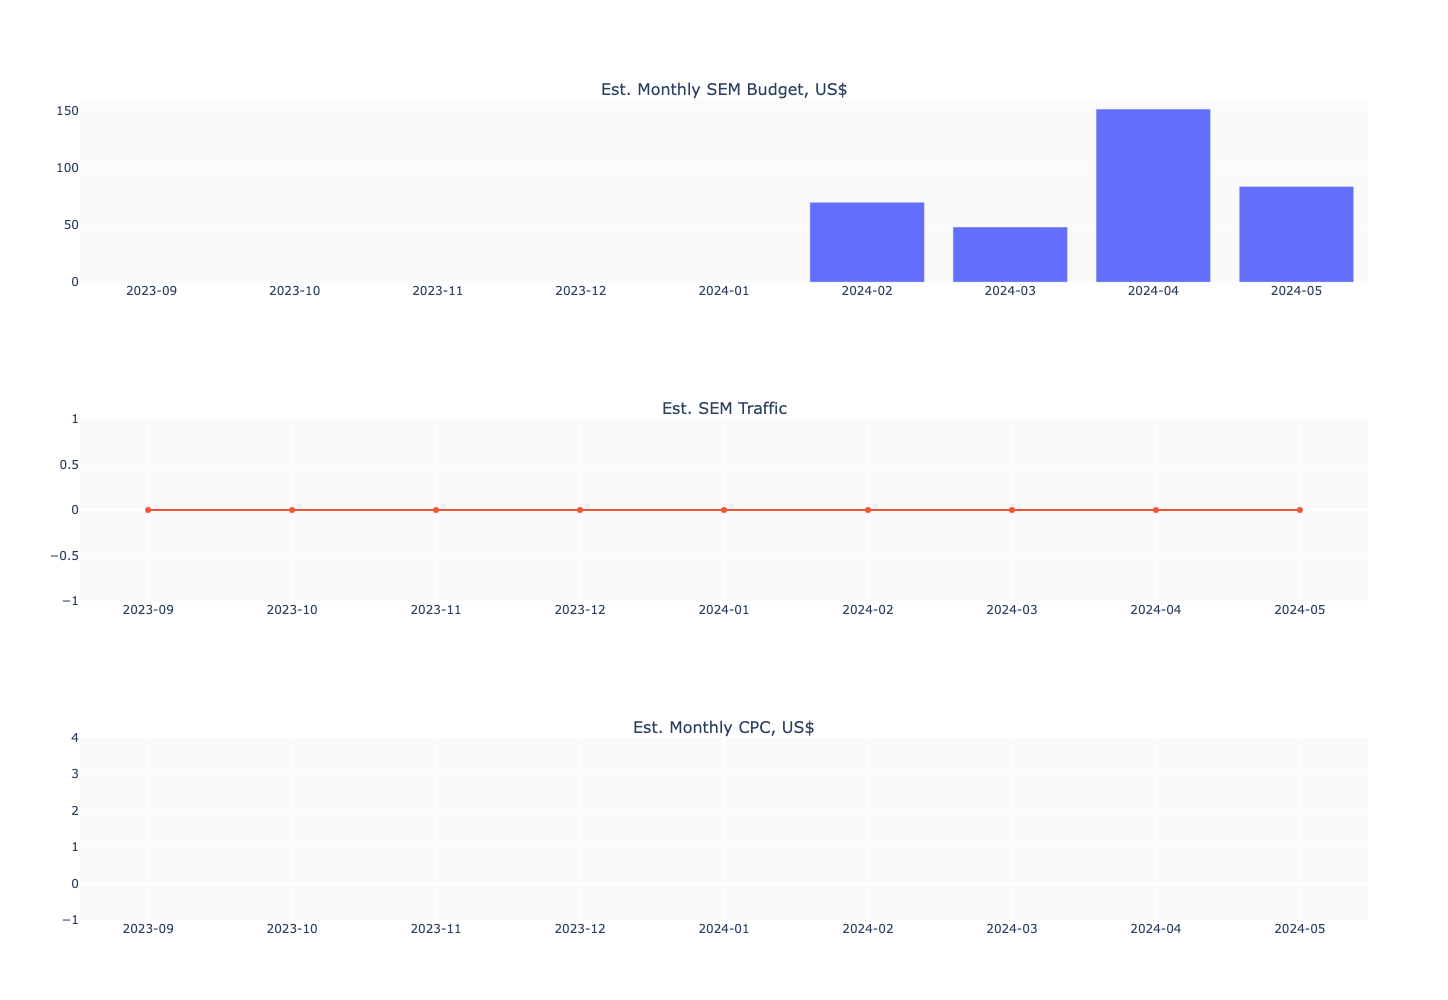

WARNING, FILE WILL BE MADE PUBLIC!
File /tmp/sem_traffic_budget_per_month.png uploaded to kaya-apps-00-public/proposal/2rFE0i58OwiG2S7eroAZ/e4r1KpsJsZ0YOwld8hxZ/sem_traffic_budget_per_month.png.
Doc e4r1KpsJsZ0YOwld8hxZ updated
Saved to FS




In [94]:
faq_list_to_save = []
for ch in channels_with_ads:
    # filter
    ch_name = ch.replace('_', ' ').title()
    print("Processing......", ch, ch_name)
    
    channel_df = all_ads_df[all_ads_df['platform'] == ch]
    
    if channel_df.shape[0] == 0:
        print("No ads found.. Skipping..")
        continue
        
    channel_df.head()
    
    if ch in ['tiktok_ads', 'bing_ads']:
        print("Skipping ", ch)
        continue
    elif ch == 'google_ads':
        faq_list_to_save += generate_sem_insight(gads_copies_df, faq_list_to_save, channel_df, search_budget_n_traffic_df)
    else:
        faq_list_to_save += generate_paid_social_insight(channel_df, faq_list_to_save)
    print("========\n\n")

In [95]:
channel_df

platform   channels        format    advertiser_social_id  \
0  google_ads   [search]          text  AR08594132424315633665   
1  google_ads   [search]          text  AR08594132424315633665   
2  google_ads   [search]          text  AR08594132424315633665   
3  google_ads  [display]  image_single  AR08594132424315633665   
4  google_ads   [search]          text  AR08594132424315633665   
5  google_ads   [search]          text  AR08594132424315633665   

          advertiser_name                   ad_id  \
0  William Stone Cressman  CR18175758334848663553   
1  William Stone Cressman  CR15508560485569003521   
2  William Stone Cressman  CR15142073812419346433   
3  William Stone Cressman  CR11568504135581958145   
4  William Stone Cressman  CR06231332513759887361   
5  William Stone Cressman  CR06108327948937330689   

                                           image_url video_url  first_seen  \
0  https://tpc.googlesyndication.com/archive/simg...      None  2024-02-05   
1  https://tpc.googlesyndication.com/archive/simg...      None  2024-02-05   
2  https://tpc.googlesyndication.com/archive/simg...      None  2024-02-05   
3  https://tpc.googlesyndication.com/archive/simg...      None  2024-05-06   
4  https://tpc.googlesyndication.com/archive/simg...      None  2024-02-04   
5  https://tpc.googlesyndication.com/archive/simg...      None  2024-02-05   

    last_seen  ...          platform_format probability first_seen_month  \
0  2024-06-27  ...          google_ads_text         1.0          2024-02   
1  2024-06-26  ...          google_ads_text         1.0          2024-02   
2  2024-06-26  ...          google_ads_text         1.0          2024-02   
3  2024-06-03  ...  google_ads_image_single         1.0          2024-05   
4  2024-05-03  ...          google_ads_text         1.0          2024-02   
5  2024-06-26  ...          google_ads_text         1.0          2024-02   

  first_seen_dt last_seen_month last_seen_dt headline body  \
0    2024-02-05         2024-06   2024-06-27                 
1    2024-02-05         2024-06   2024-06-26                 
2    2024-02-05         2024-06   2024-06-26                 
3    2024-05-06         2024-06   2024-06-03                 
4    2024-02-04         2024-05   2024-05-03                 
5    2024-02-05         2024-06   2024-06-26                 

  headline_word_count body_word_count  
0                   0               0  
1                   0               0  
2                   0               0  
3                   0               0  
4                   0               0  
5                   0               0  

[6 rows x 34 columns]

# Save to Firestore

## Breakdown for all channels

In [96]:
faq_list_to_save = remove_duplicates_from_list_of_dict(faq_list_to_save)

In [97]:
_FS.update_document(
    "proposal_companies",
    proposal_company_id,
    {
        "collapsible": faq_list_to_save
    }
)

Doc e4r1KpsJsZ0YOwld8hxZ updated
